# Annotating cell clusters by integrating single-cell RNA-seq data

## Introduction

In this tutorial we will integrate single-cell RNA-seq data to annotate the cells in our ATAC-seq data. Before we begin, you should have read the [Standard Pipeline tutorial](https://kzhang.org/SnapATAC2/tutorials/pbmc.html) and known how to obtain the gene activity matrix.

In addition to SnapATAC2, we will utilize [scanpy](https://scanpy.readthedocs.io/en/stable/) and [scvi-tools](https://scvi-tools.org/) to perform the integration.

In [1]:
import snapatac2 as snap
import scanpy as sc
import scvi
import numpy as np

snap.__version__

2022-09-24 16:26:50,541 >>> Global seed set to 0


'2.1.0.1'

## Preparing data

Let's first analyze the single-cell RNA-seq data from PBMCs. We will closely follow the scanpy tutorials here. For more details, please read the scanpy documentation.

We first import the reference single-cell RNA-seq data in which the cells have been annotated.

In [2]:
reference = sc.read(snap.datasets.pbmc_multiome())
reference

AnnData object with n_obs × n_vars = 9631 × 29095
    obs: 'domain', 'cell_type'
    var: 'gene_ids', 'feature_types'

We then import the gene activity matrix of single-cell ATAC-seq data. If you don't know how to get the gene activity matrix, please read the [Standard Pipeline tutorial](https://kzhang.org/SnapATAC2/tutorials/pbmc.html).

In [3]:
query = sc.read(snap.datasets.pbmc5k(type='gene'))
query

AnnData object with n_obs × n_vars = 4363 × 60606
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_score', 'is_doublet', 'leiden'

Finally, we merge reference data and query data together and use the scanpy library to find out highly variable genes. After this, we are ready to utilize scvi-tools to perform the integration.

In [4]:
data = reference.concatenate(query, batch_categories=["reference", "query"])
data

/home/kaizhang/data/software/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 13994 × 20169
    obs: 'domain', 'cell_type', 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_score', 'is_doublet', 'leiden', 'batch'
    var: 'gene_ids-reference', 'feature_types-reference'

In [5]:
data.layers["counts"] = data.X.copy()
sc.pp.filter_genes(data, min_cells=5)
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(
    data,
    n_top_genes = 5000,
    flavor="seurat_v3",
    layer="counts",
    batch_key="batch",
    subset=True
)

## Data integration

First we setup the scvi-tools to pretrain the model.

In [6]:
scvi.model.SCVI.setup_anndata(data, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(
    data,
    n_layers=2,
    n_latent=30,
    gene_likelihood="nb",
    dispersion="gene-batch",
)

2022-09-24 16:27:03,643 >>> Remote TPU is not linked into jax; skipping remote TPU.
2022-09-24 16:27:03,644 >>> Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
2022-09-24 16:27:03,644 >>> Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2022-09-24 16:27:03,645 >>> Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2022-09-24 16:27:03,646 >>> Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


In [7]:
vae.train(max_epochs=1000, early_stopping=True)

2022-09-24 16:27:03,774 >>> Created a temporary directory at /tmp/tmp4or9ufq4
2022-09-24 16:27:03,775 >>> Writing /tmp/tmp4or9ufq4/_remote_module_non_scriptable.py
2022-09-24 16:27:03,828 >>> GPU available: True, used: True
2022-09-24 16:27:03,829 >>> TPU available: False, using: 0 TPU cores
2022-09-24 16:27:03,830 >>> IPU available: False, using: 0 IPUs
2022-09-24 16:27:03,830 >>> HPU available: False, using: 0 HPUs
2022-09-24 16:27:04,717 >>> LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 438/1000:  44%|███████████████████████████████████████████████████▋                                                                  | 438/1000 [07:11<09:14,  1.01it/s, loss=2.55e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2621.128. Signaling Trainer to stop.


Let's plot the training history and make sure the model has converged.

<AxesSubplot:xlabel='epoch'>

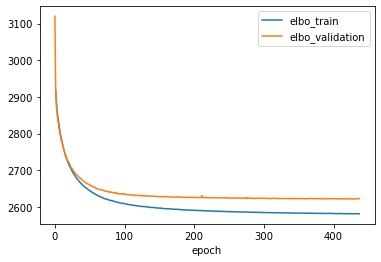

In [8]:
ax = vae.history['elbo_train'][1:].plot()
vae.history['elbo_validation'].plot(ax=ax)

In [9]:
data.obs["celltype_scanvi"] = 'Unknown'
ref_idx = data.obs['batch'] == "reference"
data.obs["celltype_scanvi"][ref_idx] = data.obs['cell_type'][ref_idx]

/tmp/ipykernel_16299/134013430.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs["celltype_scanvi"][ref_idx] = data.obs['cell_type'][ref_idx]


In [10]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=data,
    labels_key="celltype_scanvi",
    unlabeled_category="Unknown",
)

In [11]:
lvae.train(max_epochs=1000, n_samples_per_label=100)

INFO     Training for 1000 epochs.                                                           


2022-09-24 16:34:16,996 >>> GPU available: True, used: True
2022-09-24 16:34:16,997 >>> TPU available: False, using: 0 TPU cores
2022-09-24 16:34:16,997 >>> IPU available: False, using: 0 IPUs
2022-09-24 16:34:16,998 >>> HPU available: False, using: 0 HPUs
2022-09-24 16:34:17,007 >>> LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [34:48<00:00,  2.09s/it, loss=2.68e+03, v_num=1]


<AxesSubplot:xlabel='epoch'>

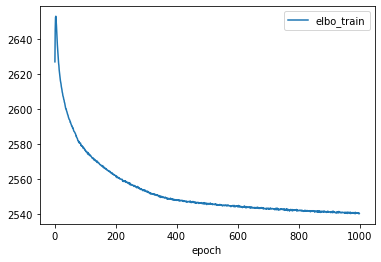

In [12]:
lvae.history['elbo_train'][1:].plot()

We now can perform the label transfer/prediction and obtain the joint embedding of reference and query data.

In [13]:
data.obs["C_scANVI"] = lvae.predict(data)
data.obsm["X_scANVI"] = lvae.get_latent_representation(data)

In [14]:
sc.pp.neighbors(data, use_rep="X_scANVI")
sc.tl.umap(data)

... storing 'celltype_scanvi' as categorical
... storing 'C_scANVI' as categorical


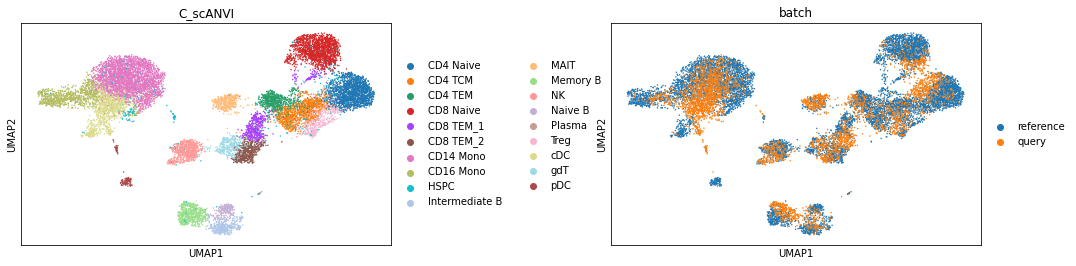

In [15]:
sc.pl.umap(data, color=['C_scANVI', "batch"], wspace=0.45)

Save the predicted cell type labels back to the original cell by bin matrix.

In [22]:
atac = sc.read(snap.datasets.pbmc5k(type="h5ad"))
obs = data.obs
obs = obs[obs['batch'] == 'query']
obs.index = list(map(lambda x: x.split("-query")[0], obs.index))
atac.obs['cell_type'] = obs.loc[atac.obs.index]['C_scANVI']

We can see that the predicted cell type labels are pretty consistent with the leiden cluster labels. Since our ATAC-seq data has fewer cells, we do not have the power to separate CD8 T and CD4 T cells, as well as a few other subtypes.

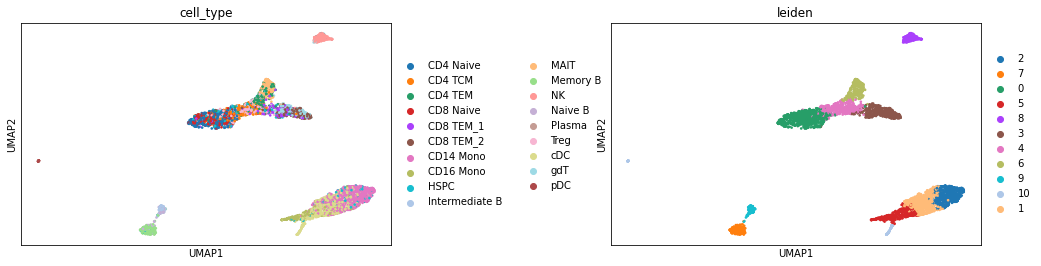

In [23]:
sc.pl.umap(atac, color=['cell_type', "leiden"], wspace=0.45)

In [24]:
from collections import Counter

cell_type_labels = np.unique(atac.obs['cell_type'])

count_table = {}
for cl, ct in zip(atac.obs['leiden'], atac.obs['cell_type']):
    if cl in count_table:
        count_table[cl].append(ct)
    else:
        count_table[cl] = [ct]

mat = []
for cl, counts in count_table.items():
    c = Counter(counts)
    c = np.array([c[ct] for ct in cell_type_labels])
    c = c / c.sum()
    mat.append(c)

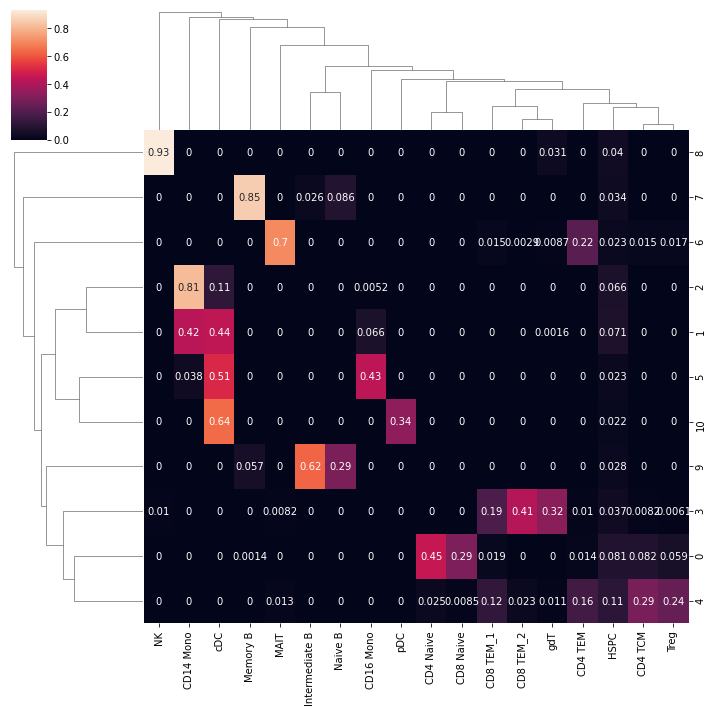

In [25]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(
    mat,
    index = count_table.keys(),
    columns = cell_type_labels,
)
sn.clustermap(df_cm, annot=True)

Let's mannually refine the cell type labels at the leiden cluster level, and save the result.

In [62]:
annotation = {
    "0": "Naive T",
    "1": "CD14 Mono_1",
    "2": "CD14 Mono_2",
    "3": "CD8 TEM",
    "4": "Memory T",
    "5": "CD16 Mono",
    "6": "MAIT",
    "7": "Memory B",
    "8": "NK",
    "9": "Naive/Intermediate B",
    "10": "DC",
}

atac.obs['cell_type'] = [annotation[i] for i in atac.obs['leiden']]
atac.write("pbmc5k_annotated.h5ad", compression="gzip")

... storing 'cell_type' as categorical


## What's next?

- [Differential peak analysis](https://kzhang.org/SnapATAC2/tutorials/diff.html)